In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

In [2]:
data = loadmat('anomaly_data.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

In [3]:
X = data['X']
X.shape

(307, 2)

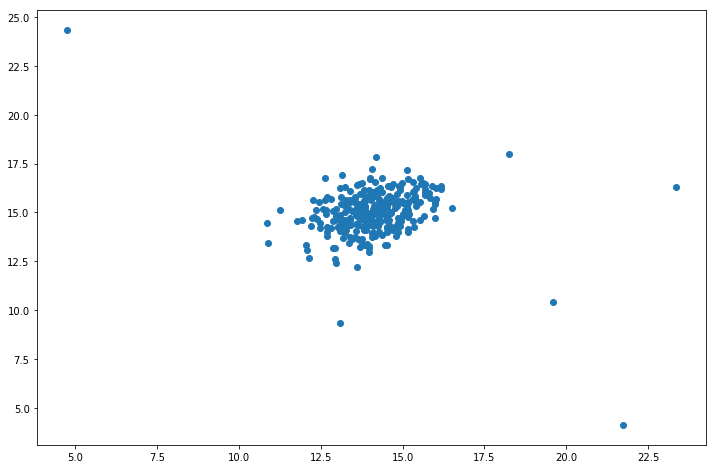

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])

In [5]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [6]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [7]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [8]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

In [9]:
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

In [10]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

In [11]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

In [12]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [13]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

/Users/gstein/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.009566706005956842, 0.7142857142857143)

In [14]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

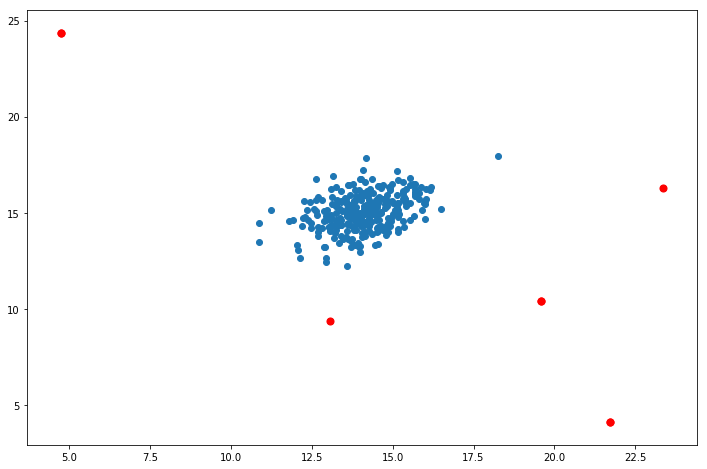

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')